In [263]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import json
import os
import datetime as dt
import re
import folium
from folium.plugins import HeatMap

from geopy import distance
from pandas.api.types import CategoricalDtype

# Helper Functions

In [352]:
m = folium.Map([-34.62, -58.4], zoom_start=12)

def crear_heatmap(df, labels): # labes = lat, lon y variable a plotear
    data_heat = df[labels]
    m = folium.Map([-34.62, -58.4], zoom_start=12)
    for i in range(len(df)):
        folium.Circle(
                location=[df.iloc[i][labels[0]], df.iloc[i][labels[1]]],
#                 print (location),
                radius=10,
    #             color = color,
                opacity=0.8,
    #             popup = ('Precio: ' + str(df.iloc[i].price_usd_per_m2).capitalize() + '<br>'
    #                      'Tipo de casa: ' + str(df.iloc[i].property_type) + '<br>'

                        ).add_to(m)
    
    m.add_child(HeatMap(data_heat, 
                        radius=8.4, 
                        min_opacity=1,
                        max_val =2,
                        blur=15,
                        gradient ={0.25: "blue", 
                                  0.50: "green",                              
                                  0.75: "yellow", 
                                  1: "red"                
                       }))
    folium.LayerControl().add_to(m)
    return m

In [179]:
df = pd.read_csv("recorridos bicicleta/reducido_genero.csv", index_col="Unnamed: 0")
df = df.drop(columns="Unnamed: 0.1" )

In [71]:
hombres = df.loc[df.genero_usuario=="M"]
mujeres = df.loc[df.genero_usuario=="F"]

In [40]:
df.dtypes

periodo                                int64
genero_usuario                        object
fecha_origen_recorrido        datetime64[ns]
id_estacion_origen                     int64
nombre_estacion_origen                object
long_estacion_origen                 float64
lat_estacion_origen                  float64
domicilio_estacion_origen             object
duracion_recorrido                    object
fecha_destino_recorrido       datetime64[ns]
id_estacion_destino                    int64
nombre_estacion_destino               object
long_estacion_destino                float64
lat_estacion_destino                 float64
domicilio_estacion_destino            object
id_usuario                            object
Route Id                              object
dtype: object

In [184]:
df["fecha_origen_recorrido"] = pd.to_datetime(df['fecha_origen_recorrido'])
df["fecha_destino_recorrido"] = pd.to_datetime(df['fecha_destino_recorrido'])

In [187]:
# df["duracion_recorrido"]= (df["fecha_destino_recorrido"]-df["fecha_origen_recorrido"]).astype('timedelta64[m]')
df['date'] = df['fecha_origen_recorrido'].apply(lambda x: x.date)


<AxesSubplot:xlabel='duracion_recorrido'>

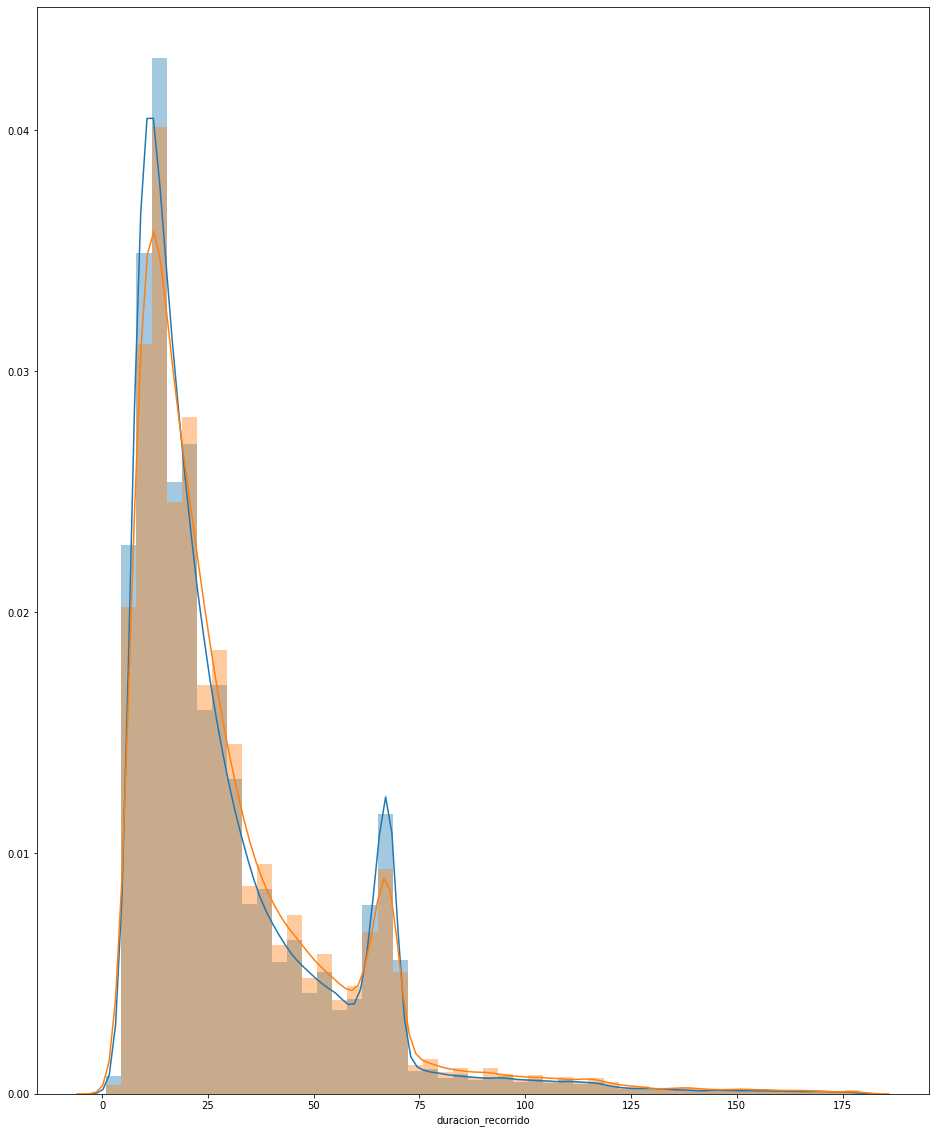

In [83]:
plt.figure(figsize=(16, 20))
sns.distplot(hombres["duracion_recorrido"])
sns.distplot(mujeres["duracion_recorrido"])


In [94]:
# Extract the unique routes from the data with their start and end coordinates
maps = df[['Route Id', 'id_estacion_origen', 'lat_estacion_origen', 'long_estacion_origen', 'id_estacion_destino', 'lat_estacion_destino', 'long_estacion_destino']].drop_duplicates()
maps['Distance'] = maps.apply(lambda x: distance.distance((x['lat_estacion_origen'], x['long_estacion_origen']), (x["lat_estacion_destino"], x['long_estacion_destino'])).km * 1000, axis=1)

# Merge the distance calculation with the main DataFrame
df = df.merge(maps[['Route Id', 'Distance']], how='left', on='Route Id')
df = df[[x for x in df.columns if not 'From' in x and not 'To' in x and x != 'Route Id']]

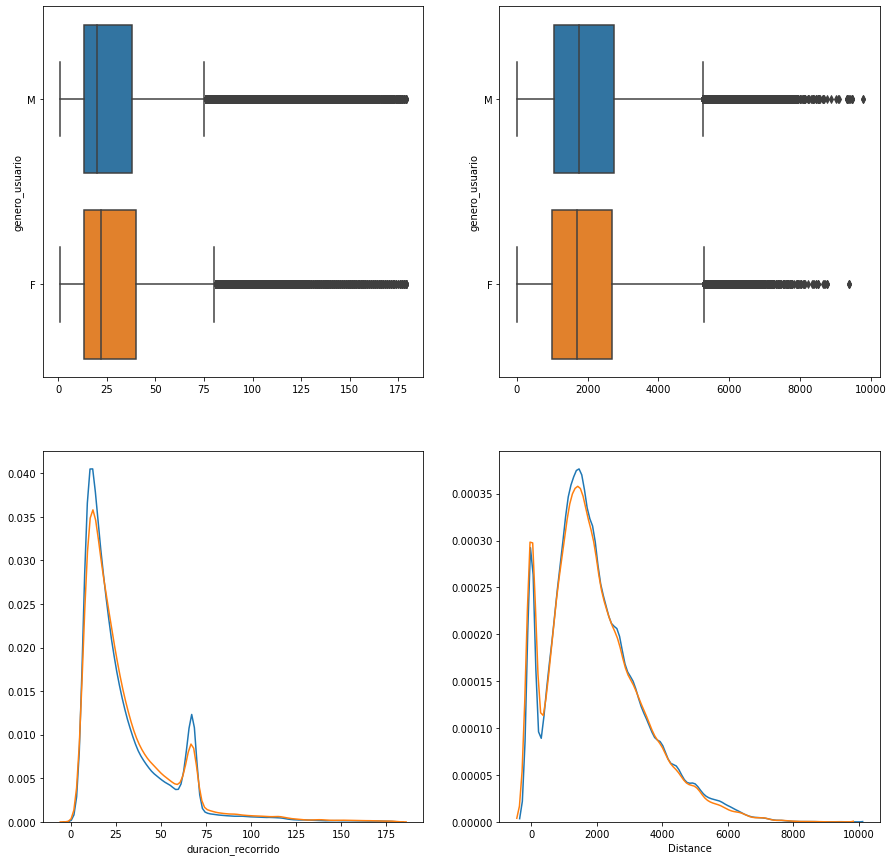

In [152]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 15))
for i, col in enumerate(['duracion_recorrido', 'Distance']):
    # Graph the distribution plots (seaborn doesn't allow default separation for distplot)
    for j, user in enumerate(df['genero_usuario'].unique()):
        sns.distplot(df[df['genero_usuario']==user][col], hist=False, ax=ax2[i])
    
    # Graph the boxplots
    sns.boxplot(x=col, y='genero_usuario', data=df, ax=ax1[i])
    ax1[i].set_xlabel('')

In [191]:
df_conid = df
df_conid.dropna(subset=['id_usuario'], how='all', inplace=True)

In [192]:
# Create the day of week Category by iterrating over 7 days (March 4th, 2019 is a Monday)
days = [(dt.datetime(2019, 3, 4) + dt.timedelta(days=x)).strftime('%a') for x in range(0, 7)]
day_type = CategoricalDtype(categories=days, ordered=True)

# Create the month Category by iterrating over the months
months = [dt.datetime(2019, x, 1).strftime('%B') for x in range(1, 13)]
month_type = CategoricalDtype(categories=months, ordered=True)

In [193]:
df_conid['Date'] = df_conid['fecha_origen_recorrido'].apply(lambda x: x.strftime('%Y-%m-%d'))
df_conid['Quarter'] = df_conid['fecha_origen_recorrido'].apply(lambda x: int((int(x.strftime('%m')) - 1) / 3) + 1)
df_conid['Month'] = df_conid['fecha_origen_recorrido'].apply(lambda x: x.strftime('%B')).astype(month_type)
df_conid['Day of Week'] = df_conid['fecha_origen_recorrido'].apply(lambda x: x.strftime('%a')).astype(day_type)
df_conid['Hour'] = df_conid['fecha_origen_recorrido'].apply(lambda x: x.strftime('%H'))

In [194]:
# Aggregate the ridership by date fields and user type and count the number of unique trips
ridership = df_conid.groupby(['Date', 'Quarter', 'Month', 'Day of Week', 'genero_usuario'])['id_usuario']\
              .nunique().reset_index().sort_values('Date', ascending=True)

C:\Users\Iago\.conda\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


AttributeError: 'FacetGrid' object has no attribute 'show'

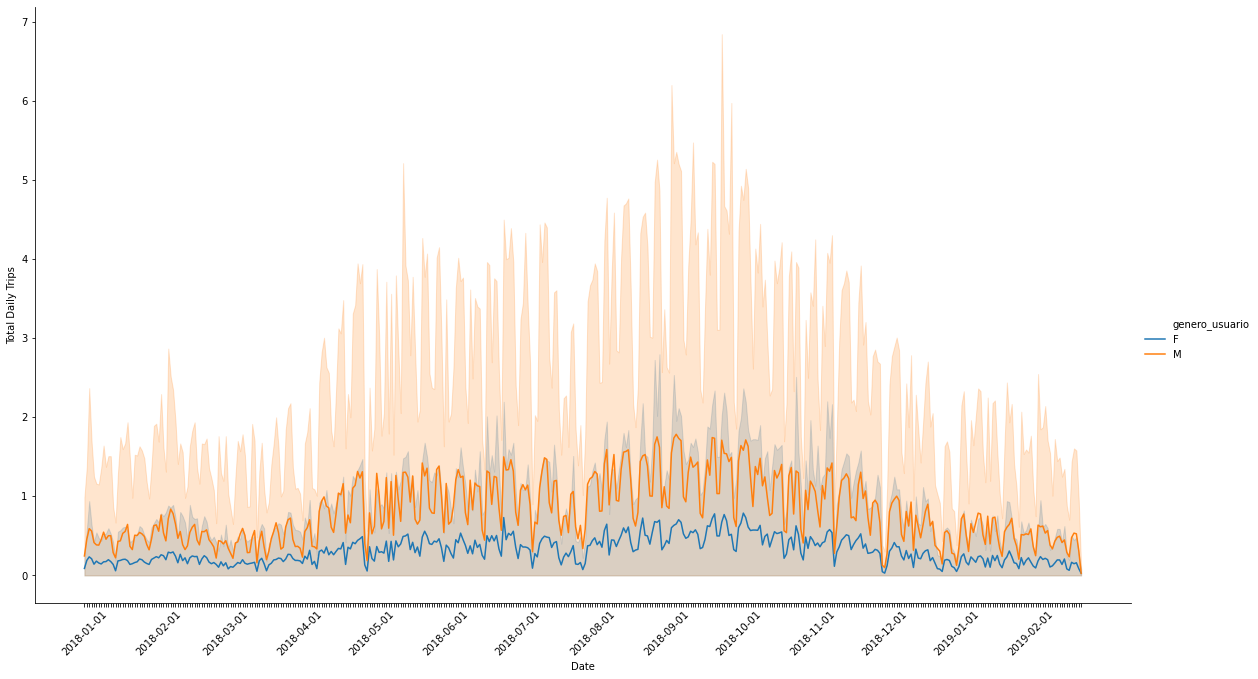

In [196]:
p = sns.relplot(x='Date', y='id_usuario', hue='genero_usuario', data=ridership, kind='line', height=9, aspect=16/9.)
p.ax.set_ylabel('Total Daily Trips')

# Limit the number of labels shown on the x-axis to only show the first day of each month
p.ax.set_xticklabels([x.set_text('') if not x.get_text().endswith('-01') else x for x in p.ax.get_xticklabels()], rotation=45)
p.show()

In [249]:
df_origen = df.groupby("id_estacion_origen")
viajes_por_origen = df_origen.count()["periodo"]
viajes_por_origen

id_estacion_origen
1      1640
2       854
3       258
4       808
5      1903
       ... 
196     270
197     727
198     149
199    1014
200    1300
Name: periodo, Length: 196, dtype: int64

In [277]:
estaciones_origen = df[['id_estacion_origen', 'nombre_estacion_origen', 'long_estacion_origen',
       'lat_estacion_origen', 'domicilio_estacion_origen']]
estaciones_origen = estaciones_origen.drop_duplicates(subset=("id_estacion_origen")).sort_values("id_estacion_origen").reset_index()
estaciones_origen=estaciones_origen.set_index("id_estacion_origen").drop(columns="index")
estaciones_origen["cant_viajes"] =viajes_por_origen

In [269]:
df.columns

Index(['periodo', 'genero_usuario', 'fecha_origen_recorrido',
       'id_estacion_origen', 'nombre_estacion_origen', 'long_estacion_origen',
       'lat_estacion_origen', 'domicilio_estacion_origen',
       'duracion_recorrido', 'fecha_destino_recorrido', 'id_estacion_destino',
       'nombre_estacion_destino', 'long_estacion_destino',
       'lat_estacion_destino', 'domicilio_estacion_destino', 'id_usuario',
       'Route Id', 'Date', 'date', 'Quarter', 'Month', 'Day of Week', 'Hour'],
      dtype='object')

In [272]:
df_destino = df.groupby("id_estacion_destino")
viajes_por_destino = df_destino.count()["periodo"]
viajes_por_destino

id_estacion_destino
1      1651
2       749
3       316
4       802
5      1615
       ... 
196     266
197     688
198     121
199    1070
200    1328
Name: periodo, Length: 196, dtype: int64

In [278]:
estaciones_destino = df[['id_estacion_destino',
       'nombre_estacion_destino', 'long_estacion_destino',
       'lat_estacion_destino', 'domicilio_estacion_destino']]
estaciones_destino = estaciones_destino.drop_duplicates(subset=("id_estacion_destino")).sort_values("id_estacion_destino").reset_index()
estaciones_destino=estaciones_destino.set_index("id_estacion_destino").drop(columns="index")
estaciones_destino["cant_viajes"] = viajes_por_destino

In [317]:
crear_heatmap(estaciones_origen, ['lat_estacion_origen', 'long_estacion_origen', "cant_viajes" ])

In [318]:
crear_heatmap(estaciones_destino, ['lat_estacion_destino', 'long_estacion_destino', "cant_viajes" ])

In [351]:
estaciones_origen = df[['id_estacion_origen', 'nombre_estacion_origen', 'long_estacion_origen',
       'lat_estacion_origen', 'domicilio_estacion_origen']]
estaciones_origen = estaciones_origen.drop_duplicates(subset=("id_estacion_origen")).sort_values("id_estacion_origen").reset_index()
estaciones_origen=estaciones_origen.set_index("id_estacion_origen").drop(columns="index")

df["hour"] = df.fecha_origen_recorrido.dt.hour
por_hora = df.groupby(["id_estacion_origen", "hour"])["periodo"].count().unstack(1).replace(np.nan, 0)
por_hora[['lat_estacion_origen', 'long_estacion_origen']] = estaciones_origen [['lat_estacion_origen', 'long_estacion_origen']]
por_hora

hour,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,lat_estacion_origen,long_estacion_origen
id_estacion_origen,,,,,,,,,,,,,,,,,,,,,
1,19.0,11.0,6.0,2.0,0.0,3.0,9.0,21.0,68.0,56.0,...,157.0,201.0,203.0,140.0,124.0,70.0,20.0,9.0,-34.583133,-58.392452
2,2.0,5.0,2.0,0.0,1.0,1.0,6.0,27.0,83.0,102.0,...,52.0,87.0,91.0,37.0,21.0,13.0,6.0,5.0,-34.592589,-58.374822
3,1.0,1.0,2.0,1.0,0.0,0.0,1.0,22.0,17.0,10.0,...,18.0,20.0,13.0,7.0,3.0,3.0,2.0,2.0,-34.611242,-58.368918
4,0.0,5.0,3.0,1.0,0.0,9.0,9.0,30.0,50.0,37.0,...,90.0,93.0,68.0,28.0,22.0,10.0,8.0,3.0,-34.601721,-58.368950
5,39.0,26.0,12.0,10.0,10.0,10.0,23.0,43.0,53.0,73.0,...,139.0,162.0,191.0,174.0,137.0,93.0,54.0,57.0,-34.580127,-58.420997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2.0,1.0,0.0,1.0,1.0,3.0,4.0,10.0,19.0,20.0,...,17.0,28.0,21.0,10.0,18.0,6.0,6.0,3.0,-34.627776,-58.366019
197,27.0,14.0,13.0,3.0,2.0,11.0,16.0,35.0,27.0,20.0,...,50.0,60.0,64.0,53.0,55.0,43.0,24.0,22.0,-34.613596,-58.423481
198,6.0,4.0,0.0,0.0,0.0,1.0,1.0,7.0,8.0,6.0,...,7.0,18.0,16.0,6.0,5.0,5.0,3.0,6.0,-34.634380,-58.404138
